In [ ]:
import pandas as pd 
import numpy as np
import os
from os import walk
import statistics
from matplotlib import pyplot as pt
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mannwhitneyu
import math 
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from tqdm.notebook import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
#from google.colab import drive

#drive.mount('/content/gdrive')
import pickle

In [ ]:
# Getting back the objects:
with open('preprocessing.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    df_feat, df_nft, df, pd_patients = pickle.load(f)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, VotingClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from os import cpu_count
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, SVR
from collections import namedtuple
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn import svm
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,cross_val_score,RandomizedSearchCV,GridSearchCV,GroupKFold, KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import lightgbm
import seaborn as sns
import umap.umap_ as umap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Getting back the objects:
import pickle
import os 
#os.chdir("/content/drive/MyDrive/TFM")
os.chdir("/Users/mariabaeza/Desktop/Universidad/BigData/TFM")
with open('features.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    data,X,y,a,groups,df_demo, pd_patients = pickle.load(f)
logo = LeaveOneGroupOut()
cv = logo.split(X,y,groups)

In [ ]:
data.corr().style.background_gradient(cmap='coolwarm')

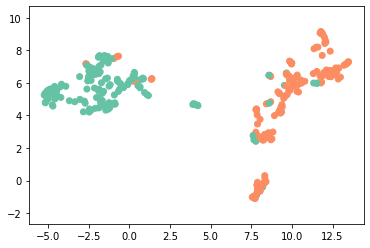

In [ ]:
import umap.umap_ as umap
X_t=[]
umapModel = umap.UMAP(n_neighbors = 5, n_components=2,random_state=42, metric = "hamming")
#imp = IterativeImputer(random_state=0, estimator=BayesianRidge())
imp = SimpleImputer()
X_t = preprocessing.StandardScaler().fit_transform(data)
X_t = pd.DataFrame(imp.fit_transform(X_t), columns= data.columns)
embedding = umapModel.fit_transform(X_t)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette("Set2")[x] for x in data.Class])
plt.gca().set_aspect('equal', 'datalim')
plt.savefig('/Users/mariabaeza/Desktop/Universidad/BigData/TFM/Resultados/umap.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

explained variance ratio (first two components): [0.26046188 0.09011219]


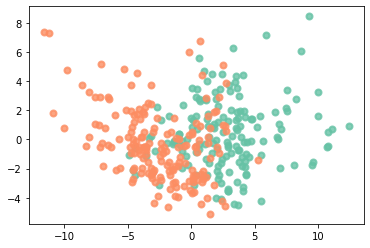

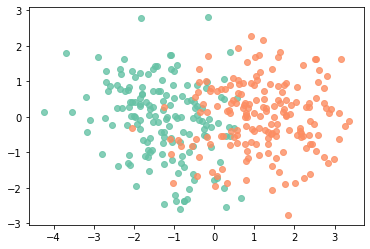

In [ ]:
pca = PCA(n_components=2)

X_r = pca.fit(X_t).transform(X_t)
X_imp = SimpleImputer().fit_transform(X)
lda = LinearDiscriminantAnalysis(n_components=1)
X_r2 = LinearDiscriminantAnalysis(n_components=1).fit_transform(X_imp,y)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]]
lw = 2
target_names = ["Healthy", "Parkinson"]

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

plt.savefig('/Users/mariabaeza/Desktop/Universidad/BigData/TFM/Resultados/pca.eps', format='eps')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], np.random.normal(0, 1, len(X_r2[y == i])), alpha=.8, color=color,
                label=target_name)

plt.savefig('/Users/mariabaeza/Desktop/Universidad/BigData/TFM/Resultados/lda.eps', format='eps')

plt.show()